<a href="https://colab.research.google.com/github/ujeongmin/ESAA/blob/main/ESAA_HW_10_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [CH3 평가]
### 분류의 성능 평가 지표
* 정확도, 오차행렬, 정밀도, 재현율, F1 스코어, ROC AUC


---


### 01. 정확도(Accuracy)
* 정확도 = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건
* 직관적으로 모델 예측 성능을 나타내는 평가 지표지만 데이터의 분류에 따라 ML 모델의 성능을 왜곡할 수 있음

In [1]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
  # fit() 메서드는 아무것도 학습하지 않음
  def fit(self, X, y=None):
    pass
  # predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함
  def predict(self, X):
    pred = np.zeros((X.shape[0],1))
    for i in range (X.shape[0]):
      if X['Sex'].iloc == 1:
        pred[i] = 0
      else:
        pred[i] = 1

    return pred

* 이제 생성된 MyDummyClassifier를 이용해 앞 장의 타이타닉 생존자 예측을 수행

In [2]:
# 앞 장에서 정리했던 함수들
from sklearn import preprocessing

# Null 처리 함수
def fillna(df):
  df['Age'].fillna(df['Age'].mean(), inplace=True)
  df['Cabin'].fillna('N', inplace=True)
  df['Embarked'].fillna('N', inplace=True)
  df['Fare'].fillna(0, inplace=True)
  return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
  df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
  return df

# 레이블 인코딩 수행
def format_features(df):
  df['Cabin'] = df['Cabin'].str[:1]
  features = ['Cabin','Sex','Embarked']
  for feature in features:
    le = preprocessing.LabelEncoder()
    le = le.fit(df[feature])
    df[feature] = le.transform(df[feature])
  return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
  df = fillna(df)
  df = drop_features(df)
  df = format_features(df)
  return df

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
from google.colab import drive
drive.mount('/content/gdrive')
titanic_df = pd.read_csv('/content/gdrive/MyDrive/ESAA/data/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                    test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Mounted at /content/gdrive
Dummy Classifier의 정확도는: 0.3855


* MNIST 데이터 세트 : 0부터 9까지의 숫자 이미지의 픽셀 정보 가지고 있음
* 이를 기반으로 숫자 Digit을 예측하는데 사용됨

In [4]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
  def fit(self, X,y):
    pass

    # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
  def predict(self, X):
    return np.zeros((len(X),1), dtype=bool)

# 사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7이 아니면 False이고 0으로 변환
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [5]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기:', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


* 단순히 모든 것을 0으로만 예측해도 MyFakeClassifier의 정확도가 90%가 나옴
* 불균형한 레이블 데이터 세트에서 이러한 이유 때문에 정확도 평가 지표는 사용돼서는 안됨



---

### 02. 오차 행렬
* 4분면의 왼쪽, 오른쪽을 예측된 클래스 값 기준으로 Negative, Positive로 분류하고  
위, 아래를 실제 클래스값 기준으로 Negative, Positive로 분류
* TN, FP, FN, TP 형태로 채워짐
> TN : 예측값을 Negative 0으로 예측, 실제 값 역시 Negative 0  
> FP : 예측값을 Positive 1로 예측, 실제 값은 Negative 0  
> FN : 예측값을 Negative 0으로 예측, 실제 값은 Positive 1  
> TP : 예측값을 Positive 1로 예측, 실제 값 역시 Positive 1
* confusion_matrix() API 제공

In [6]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]])

>TN FP  
FN TP

* 정확도 = ( TN + TP ) / ( TN + FP + FN + TP )
* Negative로 예측할 때만 정확도가 높기 때문에  
 비대칭한 데이터 세트에서 Positive에 대한 예측 정확도를 판단하지 못한 채 Negative에 대한 예측 정확도만으로도 분류의 정확도가 매우 높게 나타나는 수치적인 판단 오류 일어남


---

### 03. 정밀도와 재현율
* Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표
* 정밀도 = TP / ( FP + TP ) = 양성 예측도
> 정밀도가 더 중요한 지표인 경우는 실제 Negative 음성 데이터를 Positive로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
* 재현율 = TP / ( FN + TP ) = 민감도, TPR
> 재현율이 더 중요한 지표인 경우는 실제 Positive 양성 데이터를 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('/content/gdrive/MyDrive/ESAA/data/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.20, random_state=11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* 재현율에 비해 정밀도가 낮게 나옴, 재현율 또는 정밀도를 좀 더 강화할 방법은?

#### 정밀도/재현율 트레이드오프
* 분류의 결정 임곗값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높일 수 있음
* 하지만 서로 상호 보완적인 평가 지표이기 때문에 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉬움
* predict_proba() 메서드 제공
> 개별 데이터별로 예측 확률을 반환

In [15]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.46197474 0.53802526]
 [0.87872398 0.12127602]
 [0.87719492 0.12280508]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46197474 0.53802526 1.        ]
 [0.87872398 0.12127602 0.        ]
 [0.87719492 0.12280508 0.        ]]


* 반환 결과인 ndarray는 0과 1에 대한 확률을 나타내므로 첫번째 칼럼 값과 두번째 칼럼 값을 더하면 1이 됨
* 두 개의 칼럼 중에서 더 큰 확률 값으로 predict() 메서드가 최종 예측
* 사이킷런의 Binarizer 클래스 이용

In [16]:
from sklearn.preprocessing import Binarizer

X = [[1,-1,2],
     [2,0,0],
     [0,1.1,1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


* 이렇게 구한 최종 예측값에 대해 평가 지표도 출력해봄 (아래 코드)

In [17]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임곗값임
custom_threshold = 0.5

# predict_proba() 반환값의 두번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


* 앞에서 로지스틱 회귀 Classifier 객체에서 호출된 predict()로 계산된 값과 정확히 같음
* 임곗값을 0.4로 낮춰보면?

In [18]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361


* 임곗값을 낮추니 재현율이 올라가고 정밀도가 떨어짐
> 분류 결정 임곗값은 Positive 예측값을 결정하는 확률의 기준이 되기 때문  
> 확률이 0.5가 아닌 0.4부터 Positive로 예측을 더 너그럽게 하기 때문에 임곗값을 낮출수록 True 값이 많아지게 됨
* 이번에는 임곗값을 0.4부터 0.6까지 0.05씩 증가시키며 평가 지표 조사

In [19]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
  # thresholds list 객체 내의 값을 차례로 iteration 하면서 Evaluation 수행
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
    custom_predict = binarizer.transform(pred_proba_c1)
    print('임곗값:', custom_threshold)
    get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


* 재현율을 향상시키면서 다른 수치를 어느 정도 감소하는 희생을 해야 한다면 임곗값 0.45가 가장 적당해 보임

* 사이킷런은 이와 유사한 precision_recall_curve() API 제공

In [20]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 Shape:', thresholds.shape)

# 반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임계값: ', np.round(thresholds[thr_index],2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index],3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index],3))

반환된 분류 결정 임계값 배열의 Shape: (165,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임계값:  [0.01 0.09 0.11 0.13 0.15 0.23 0.35 0.5  0.63 0.75 0.89]
샘플 임계값별 정밀도:  [0.341 0.372 0.415 0.448 0.505 0.585 0.688 0.774 0.913 0.935 0.938]
샘플 임계값별 재현율:  [1.    1.    0.967 0.918 0.902 0.902 0.869 0.787 0.689 0.475 0.246]


* 10개에 해당하는 정밀도, 재현율 값 살펴보면 임계값이 증가할수록 정밀도는 동시에 높아지나 재현율은 낮아짐을 알 수 있음
* 다음은 곡선 시각화 코드

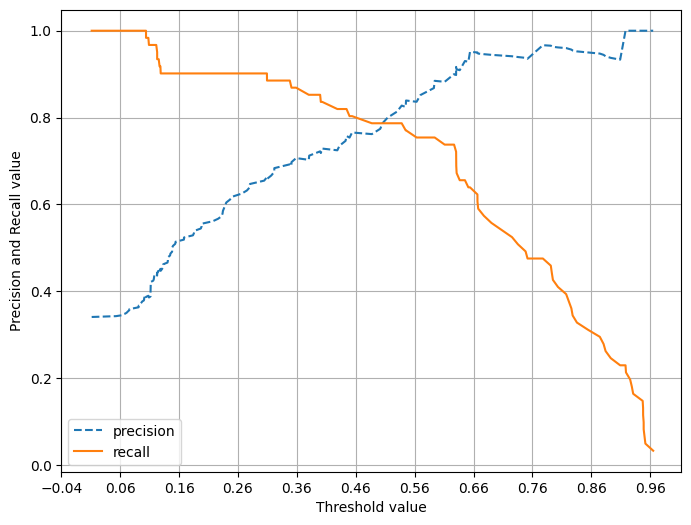

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
  # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

  # threshold 값 X축의 Scale을 0.1 단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))

  # x축, y축 label과 legend, 그리고 grid 설정
  plt.xlabel('Threshold value')
  plt.ylabel('Precision and Recall value')
  plt.legend()
  plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

* 정밀도는 점선, 재현율은 실선으로 표현했음
* 임계값이 낮을수록 많은 수의 양성 예측으로 인해 재현율 값이 극도로 높아지고 정밀도 값이 극도로 낮아짐

#### 정밀도와 재현율의 맹점
* 이러한 변경은 두 개의 수치를 상호 보완할 수 있는 수준에서 적용되어야 함
* 단순히 하나의 성능 지표 수치를 높이기 위한 수단으로 사용되어서는 안됨
* 아래는 수치 중 하나를 극단적으로 높이는 방법(숫자 놀음에 불과)  

1) 정밀도가 100%가 되는 방법
* 확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측함
> TP / (TP + FP) = 1 / (1 + 0) = 100%

2) 재현율이 100%가 되는 방법
* 모든 경우를 Positive로 예측하면 됨
> TP / (TP + FN) = 30 / (30 + 0) = 100%



---

### 04. F1 스코어
* 정밀도와 재현율을 결합한 지표
* 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 높은 값을 가짐
> F1 = 2/(1/recall + 1/precision) = 2*(precision * recall)/(precision + recall)
* f1_score() API 제공

In [26]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


* 다음은 임계값 변화시키면서 F1 스코어를 포함한 평가지표 구함

In [29]:
def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  # F1 스코어 추가
  f1 = f1_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  # f1 score print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall,f1))

thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361, F1:0.7727
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1:0.7840
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1:0.7805
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1:0.7931
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1:0.8036


* F1 스코어는 임계값이 0.6일 때 가장 좋은 값을 보여줌 (하지만 재현율이 크게 감소하고 있으니 주의)



---

### 05. ROC 곡선과 AUC
* ROC 곡선 : FPR(False Positive Rate)이 변할 때 TPR이 어떻게 변하는지를 나타내는 곡선
* TPR은 재현율, 민감도
* TNR은 특이성, 민감도에 대응하는 지표
> TNR(특이성) = TN / ( FP + TN )  
> FPR = FP / ( FP + TN ) = 1- TNR = 1 - 특이성
* ROC 곡선이 가운데 직선에 가까울수록 성능이 떨어지는 것, 멀어질수록 성능이 뛰어난 것
* roc_curve() API 제공

In [30]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임계값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임계값을 5 step으로 추출
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임계값: ', np.round(thresholds[thr_index],2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임계값별 FPR: ', np.round(fprs[thr_index],3))
print('샘플 임계값별 TPR: ', np.round(tprs[thr_index],3))

샘플 추출을 위한 임계값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임계값:  [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임계값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임계값별 TPR:  [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


* 임계값이 1에 가까운 값에서 점점 작아지면서 FPR이 점점 커짐
* 그리고 FPR이 조금씩 커질 때 TPR은 가파르게 커짐


* 다음은 FPR의 변화에 따른 TPR의 변화를 ROC 곡선으로 시각화

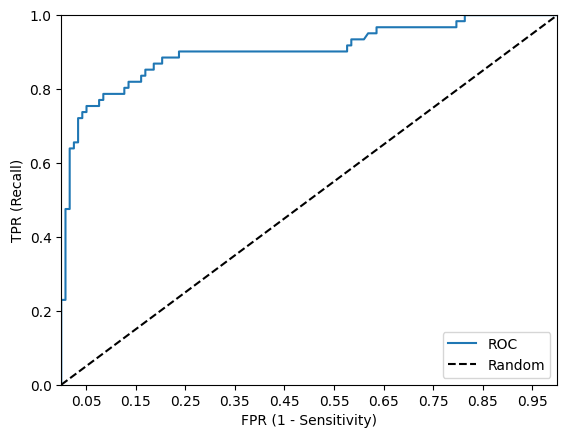

In [31]:
def roc_curve_plot(y_test, pred_proba_c1):
  # 임계값에 따른 FPR, TPR 값을 반환받음
  fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
  # ROC 곡선을 그래프 곡선으로 그림
  plt.plot(fprs, tprs, label='ROC')
  # 가운데 대각선 직선을 그림
  plt.plot([0,1],[0,1], 'k--', label='Random')

  # FPR X축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))
  plt.xlim(0,1)
  plt.ylim(0,1)
  plt.xlabel('FPR (1 - Sensitivity)')
  plt.ylabel('TPR (Recall)')
  plt.legend()

roc_curve_plot(y_test, pred_proba[:,1])

* ROC 곡선 자체는 FPR과 TPR의 변화를 보는데 이용하며  
분류의 성능 지표로 사용되는 것은 ROC 곡선 밑의 면적인 AUC (Area Under Curve)
* AUC가 1에 가까울수록 좋은 수치

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

# print(confusion_matrix(y_target, preds))
# print('정확도:', np.round(accuracy_score(y_target, preds), 4))
# print('정밀도:', np.round(precision_score(y_target, preds), 4))
# print('재현율:', np.round(recall_score(y_target, preds), 4))

* ROC AUC는 예측 확률값 기반으로 계산되므로 이를 get_clf_eval() 함수의 인자로 받을 수 있도록  
get_clf_eval(y_test, pred=None, pred_proba=None)로 함수형을 변경해줌

In [39]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  # ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  # ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, \
          F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall,f1,roc_auc))